In [1]:
import numpy as np
import pickle
import cv2
import os
import matplotlib.pyplot as plt
from os import listdir
# Scikit-learn utilities
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
# TensorFlow-Keras imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, Conv2D, MaxPooling2D, 
    Activation, Flatten, Dropout, Dense
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [2]:
# Define constants
DEFAULT_IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32
EPOCHS = 25
INITIAL_LEARNING_RATE = 0.0001
DATA_DIR = './disease'

In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None


In [4]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80% train, 20% validation
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [5]:
# Training data generator
train_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=DEFAULT_IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    follow_links=True  # Follow nested directory structure
)

Found 28221 images belonging to 19 classes.


In [6]:
# Validation data generator
validation_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=DEFAULT_IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    follow_links=True
)

Found 7045 images belonging to 19 classes.


In [7]:
# Print dataset information
print("Classes found:", train_generator.class_indices)
print("Number of training samples:", train_generator.samples)
print("Number of validation samples:", validation_generator.samples)


Classes found: {'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 4, 'Corn_(maize)___Common_rust_': 5, 'Corn_(maize)___Northern_Leaf_Blight': 6, 'Corn_(maize)___healthy': 7, 'Grape___Black_rot': 8, 'Grape___Esca_(Black_Measles)': 9, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 10, 'Grape___healthy': 11, 'Potato___Early_blight': 12, 'Potato___Late_blight': 13, 'Potato___healthy': 14, 'Tomato___Bacterial_spot': 15, 'Tomato___Leaf_Mold': 16, 'Tomato___Septoria_leaf_spot': 17, 'Tomato___healthy': 18}
Number of training samples: 28221
Number of validation samples: 7045


In [8]:
# Calculate steps for training
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

In [9]:
# Function to build CNN model
def build_model(input_shape, num_classes):
    model = Sequential()
    
    # First convolutional block
    model.add(Conv2D(32, (3, 3), padding="same", input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

# Second convolutional block
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Third convolutional block
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Fourth convolutional block
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(num_classes))
    model.add(Activation("softmax"))
    
    return model

In [10]:
# Build the model
input_shape = (*DEFAULT_IMAGE_SIZE, 3)  # (256, 256, 3)
num_classes = len(train_generator.class_indices)
model = build_model(input_shape, num_classes)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# Compile the model
opt = Adam(learning_rate=INITIAL_LEARNING_RATE)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])


In [12]:
# Print model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 512)            │             

 Total params: 17,031,763 (64.97 MB)

 Trainable params: 17,030,035 (64.96 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [13]:
# Train the model
print("[INFO] Training the network...")
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps

)


[INFO] Training the network...


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
881/881 ━━━━━━━━━━━━━━━━━━━━ 1363s 2s/step - accuracy: 0.5048 - loss: 1.7023 - val_accuracy: 0.3670 - val_loss: 4.5883
Epoch 2/25
  1/881 ━━━━━━━━━━━━━━━━━━━━ 23:45 2s/step - accuracy: 0.7812 - loss: 0.6911

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


881/881 ━━━━━━━━━━━━━━━━━━━━ 69s 77ms/step - accuracy: 0.7812 - loss: 0.6911 - val_accuracy: 0.3707 - val_loss: 4.5685
Epoch 3/25
881/881 ━━━━━━━━━━━━━━━━━━━━ 1368s 2s/step - accuracy: 0.7793 - loss: 0.6518 - val_accuracy: 0.3470 - val_loss: 8.0592
Epoch 4/25
881/881 ━━━━━━━━━━━━━━━━━━━━ 64s 71ms/step - accuracy: 0.8438 - loss: 0.4738 - val_accuracy: 0.3510 - val_loss: 7.9718
Epoch 5/25
881/881 ━━━━━━━━━━━━━━━━━━━━ 1335s 2s/step - accuracy: 0.8400 - loss: 0.4752 - val_accuracy: 0.3727 - val_loss: 9.1694
Epoch 6/25
881/881 ━━━━━━━━━━━━━━━━━━━━ 64s 71ms/step - accuracy: 0.9062 - loss: 0.3410 - val_accuracy: 0.3555 - val_loss: 9.6478
Epoch 7/25
881/881 ━━━━━━━━━━━━━━━━━━━━ 1346s 2s/step - accuracy: 0.8773 - loss: 0.3644 - val_accuracy: 0.4892 - val_loss: 4.3930
Epoch 8/25
881/881 ━━━━━━━━━━━━━━━━━━━━ 64s 72ms/step - accuracy: 0.9062 - loss: 0.2083 - val_accuracy: 0.4750 - val_loss: 4.5627
Epoch 9/25
881/881 ━━━━━━━━━━━━━━━━━━━━ 1350s 2s/step - accuracy: 0.8974 - loss: 0.3116 - val_accurac

In [14]:
# Save the model
model_filename = "plant_disease_model.h5"
model.save(model_filename)
print(f"[INFO] Model saved as {model_filename}")

# Save the class indices
class_indices = train_generator.class_indices
label_map = {v: k for k, v in class_indices.items()}
with open('label_map.pkl', 'wb') as file:
    pickle.dump(label_map, file)
print("[INFO] Class labels saved as label_map.pkl")


[INFO] Model saved as plant_disease_model.h5
[INFO] Class labels saved as label_map.pkl


In [15]:
# Plot the training history
plt.figure(figsize=(12, 5))


<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

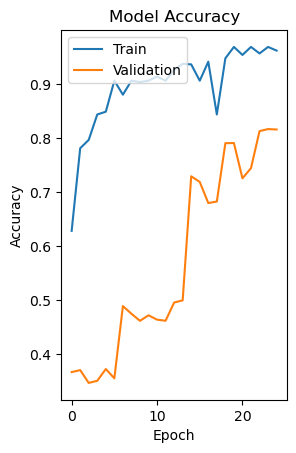

In [16]:
# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


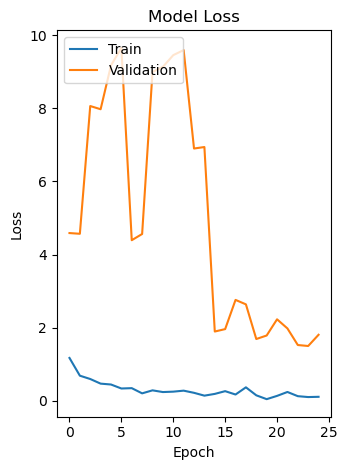

In [17]:
# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

In [18]:
# Function to make predictions on a single image
def predict_disease(image_path, model, label_map):
    # Load and preprocess the image
    image = convert_image_to_array(image_path)
    if image is None or image.size == 0:
        return "Error: Could not load image"
    
    # Prepare the image for prediction
    image = np.expand_dims(image, axis=0) / 255.0
    
    # Make prediction
    prediction = model.predict(image)
    predicted_class = np.argmax(prediction, axis=1)[0]
    
    # Map the predicted class to the disease name
    disease_name = label_map[predicted_class]
    confidence = prediction[0][predicted_class] * 100
    
    return disease_name, confidence